# Qualidade do ar e problemas respiratórios na região metropolitana de Salvador-Bahia: uma análise estatística

Comando para baixar o shapefile do terrítorio brasileiro

In [7]:
# Download Brazil territorial meshes
!wget -r -np -nH -N -R "*.html" --no-directories --directory-prefix=meshes_br2018 \
    ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR/ \
    ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Leia_me_Malha_Digital_2018.pdf

--2020-04-01 23:36:05--  ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR/
           => ‘meshes_br2018/.listing’
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 170.84.40.11
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|170.84.40.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]     501  --.-KB/s    in 0s      

2020-04-01 23:36:10 (29.0 MB/s) - ‘meshes_br2018/.listing’ saved [501]

Removed ‘meshes_br2018/.listing’.
--2020-04-01 23:36:10--  ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR/BR.zip
           => ‘meshes_br2018/BR.zip’
==> CWD not required.
==> PASV ... done.    =

Índices do IBGE dos municípios da região metropolitana de Salvador

Cidade|População [2010]|População estimada [2019]|Densidade demográfica (hab/km² )|PIB per capita [2017]|Mortalidade Infantil [2017] (óbitos/mil nascidos vivos)|Estabelecimentos de Saúde SUS [2009]|Homens <5|Mulheres <5|Homens >60|Mulheres >60
---|---|---|---|---|---|---|---|---|---|---
Salvador|2.675.656|2.872.347|3.859,44|BRL21.231,48|14,56|367|83.611|81.658|101.464|165.689
Camaçari|242.970|299.132|309,65|BRL 77.816,68|12,1|64|10.465|9.614|6.601|7.605
São Francisco do Conde|33.183|39.183|126,24|BRL 253.895,58|9,48|22|1.344|1.349|972|1.274
Lauro de Freitas|163.449|198.440|2.833,38|BRL 31.809,81|13,68|24|6.163|5.832|5.210|6.485
Simões Filho|118.047|134.377|586,65|BRL 39.118,47|14,13|17|5.064|4.973|3.411|4.091
Candeias|83.158|87.076|321,87|BRL 43.135,87|15,9|31|3.192|3.083|2.806|3.591
Dias d'Ávila|66.440|81.089|360,64|BRL 37.896,15|14,42|11|3.003|2.879|1.904|2.235
Mata de São João|40.183|46.583|63,46|BRL 22.407,10|18,23|9|1.672|1.567|1.427|1.789
Pojuca|33.066|39.519|113,97|BRL 21.834,06|17,58|17|1.249|1.262|1.129|1.388
São Sebastião do Passé|42.153|44.300|78,30|BRL 11.965,30|10,58|25|1.504|1.492|1.735|2.104
Vera Cruz|37.567|43.223|125,33|BRL 11.752,15|10,27|19|1.358|1.355|1.821|1.954
Madre de Deus|17.376|21.093|539,61|BRL 21.144,38|21,13|13|615|608|565|750
Itaparica|20.725|22.228|175,58|BRL 9.824,79|30,04|10|796|753|918|1.131

## Importação das bibliotecas

Bibliotecas que foram utilizadas durante as análises

In [1]:
from pandas_profiling import ProfileReport
from ipywidgets import interact, widgets
from IPython.display import Image
from scipy import stats

import matplotlib.dates as mdates
import matplotlib.pylab as plt
import multiprocessing as mp
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import re
import os

In [2]:
%matplotlib inline

## Variáveis globais

Indica onde estão localizados os arquivos contendo os dados:

- F_AIRQ: qualidade do ar
- F_WTHR: meteorológico
- F_DSUS: internações hospitalares
- PATH_RESULT: caminho para pasta contendo os resultados
- COLS_AIRQ: colunas de interesse do dataframe de qualidade do ar
- COLS_WTHR: colunas de interesse do dataframe meteorológico

In [3]:
F_AIRQ = '../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/airquality.csv.gz' # interval_15min
F_WTHR = '../datas/preprocessing/mr-ssa/weather/cetrel/weather.csv.gz'
F_DSUS = '../datas/preprocessing/mr-ssa/datasus/RD.csv.gz'
PATH_RESULTS = '../docs/writings/air-pollution/results'

COLS_AIRQ = [
    r'$SO_2$ (µg/m3)',
    'CO (ppm)',
    r'$O_3$ (µg/m3)',
    r'$PM_{10}$ (µg/m3)',
    r'$NO_2$ (µg/m3)',
    'NO (µg/m3)'
]

COLS_WTHR = [
    'V.VEN (m/s)',
    'D.VEN (Deg)',
    'TEMP (C°)',
    'UMID (%)',
    'CHUVA (mm)',
]

## Funções

Função para exibição de uma lista enumerada

- arr: lista a ser enumerada

return: retorna uma lista enumerada (dicionário)

In [4]:
def show_enum(arr: [str]) -> {int: str}:
    return {idx: value for (idx, value) in enumerate(arr)}

Função que recebe um dataframe como entrada e gera um dataframe de saída com a descrição dos dados.

- df: dataframe a ser descrito
- headers: colunas a serem analisadas

return: retorna um dataframe com a descrição de cada coluna

In [5]:
def describe_data(
    df: pd.DataFrame, headers: [str] = None
) -> pd.DataFrame:

    def _apply(header: str, column: []):
        _max = column.max()
        _min = column.min()

        _q1 = column.quantile(0.25)
        _q3 = column.quantile(0.75)
        _iqr = _q3 - _q1
        _lower = max(_min, _q1 - (1.5 * _iqr))
        _upper = min(_max, _q3 + (1.5 * _iqr))
            

        return {
            'header': header,
            'max': _max,
            'min': _min,
            'mean': column.mean(),
            'median': column.median(),
            'lower-limit': _lower,
            'quartile-1': _q1,
            'quartile-3': _q3,
            'upper-limit': _upper,
            'var': column.var(),
            'std': column.std(),
            'mad': column.mad(),
            'amp': _max - _min,
            'rms': (column.pow(2)).mean() ** 0.5,
            'kurtosis': column.kurtosis(),
            'skew': column.skew(),
            'count': column.count(),
            'nans': column.isna().sum(),
        }

    if not headers:
        headers = df.columns

    return pd.DataFrame(
        [_apply(h, df[h]) for h in headers]
    ).set_index('header')

Exibe a descrição dos dados e as informações do dataframe

- df: dataframe a ser descrito
- columns: colunas a serem analisadas

In [6]:
def show_describe(df: pd.DataFrame, columns: [str]) -> None:
    display(describe_data(df, columns))
    display(df.info())

Exibe o profiling do dataframe e salva em um caminho

- df: dataframe a ser analisado
- title: título a ser atribuido no profiling
- f_out: path para o arquivo de saida

In [7]:
def show_profiling(
    df: pd.DataFrame, title: str = None, f_out: str = None
) -> None:
    prof = ProfileReport(df, title=title)
    prof.to_widgets()
    if f_out:
        prof.to_file(output_file=f_out)

Função para exibir o gráfico de densidade de distribuição e boxplot

- dataset: dataframe de exibição
- out: se != None, salva o resultado no caminho informado

In [8]:
# Third-party function (Adapted from Lucas Lucas Alves)
def plot_distributions(dataset: pd.DataFrame, out: str = None) -> None:
    dataset_columns = list(dataset.columns.values)
    plt_col_num = 2
    plt_row_num = len(dataset_columns)
    
    plt.figure(figsize=(15, plt_row_num*5))
    
    for index, label in enumerate(dataset_columns):
        # Subplot for histogram and KDE
        plt.subplot(plt_row_num, plt_col_num, (2*index)+1)
        
        # Plot histogram
        ax1 = sns.distplot(dataset.loc[:, label].dropna(), hist=True, kde=False)
        ax1.set_ylabel('Frequency')
        
        # Plot KDE (Kernel Density Estimation)
        ax2 = ax1.twinx()
        sns.distplot(dataset.loc[:, label].dropna(), hist=False, kde=True, ax=ax2)
        ax2.set_ylabel('Kernel density estimation')

        # Computation of data statistics
        median = dataset.loc[:, label].median()
        quartile_1 = dataset.loc[:, label].quantile(q=0.25)
        quartile_3 = dataset.loc[:, label].quantile(q=0.75)
        min_val = dataset.loc[:, label].min()
        max_val = dataset.loc[:, label].max()
        inf_limit = max(min_val, (quartile_1 - (quartile_3-quartile_1)*1.5))
        sup_limit = min(max_val, (quartile_3 + (quartile_3-quartile_1)*1.5))
        
        # Computation of outliers
        inf_outliers = dataset.loc[dataset.loc[:, label]<inf_limit, :].shape[0]
        sup_outliers = dataset.loc[dataset.loc[:, label]>sup_limit, :].shape[0]
        inf_outliers_percent = (inf_outliers/dataset.loc[:, label].dropna().shape[0])
        sup_outliers_percent = (sup_outliers/dataset.loc[:, label].dropna().shape[0])
        
        # Plot lines indicating the statistics
        plt.axvline(x=median, linestyle='-', linewidth=1.3, color='black', label='Median')
        plt.axvline(x=quartile_1, linestyle='-', linewidth=1.3, color='green', label='1st Quartile')
        plt.axvline(x=quartile_3, linestyle='-', linewidth=1.3, color='green', label='3rd Quartile')
        plt.axvline(x=inf_limit, linestyle='-', linewidth=1.3, color='red',
                    label='Lower limit\n{:.2%} of the data below'.format(inf_outliers_percent))
        plt.axvline(x=sup_limit, linestyle='-', linewidth=1.3, color='red',
                    label='Upper limit\n{:.2%} of the data above'.format(sup_outliers_percent))
        plt.legend()
        
        # Plot boxplot in other subplot
        plt.subplot(plt_row_num, plt_col_num, (2*index)+2)
        dataset.boxplot(column=label)
        plt.ylabel('Values')
        plt.title('')
        plt.grid(True)
        
    plt.subplots_adjust(wspace=0.35, hspace=0.3)
    plt.show()
    
    if out:
        plt.savefig(out)

Conversor de ppm|ppb para µg/m3

- value: valor em ppb ou ppm
- mass: massa da molecula
- temp: temperatura
- ppx: indicador de escala ppb ou ppm

return: retorna o valor em escala µg/m3

In [9]:
def ppx2um(value: float, mass: float, temp: float, ppx: str ='ppb'):
    if ppx == 'ppm':
        value *= 1e3
    return (value*12.187*mass)/(273.15+temp)

Função para converter a escala dos poluentes de ppb para µg/m3

- row: identificador da linha
- df: dataframe para conversão
- cols: colunas de df que deseja converter
- dftp: dataframe com as temperaturas
- dtemp: temperatura padrão adotada se não encontrado no dataframe

return: retorna a linha informada com a respectiva conversão

In [10]:
func = {
    'SO2': lambda v, t, ug: ppx2um(v, 64.066, t, ug),
    'O3': lambda v, t, ug: ppx2um(v, 48, t, ug),
    'NO2': lambda v, t, ug: ppx2um(v, 46.0055, t, ug),
    'NO': lambda v, t, ug: ppx2um(v, 30.01, t, ug)
}

def convert(
    row, df: pd.DataFrame, cols: [str], dftp: pd.DataFrame, dtemp: float
):
    aux = df.loc[[row]]
    try:
        temp = dftp.loc[row, 'TEMP (C°)']
        if np.isnan(temp):
            temp = dtemp
    except KeyError:
        temp = dtemp
        
    for col in cols:
        sp = re.search(r'(.*?) ', col).group(1) # specie
        ug = re.search(r'\((.*?)\)', col).group(1) # unit_greatness
        aux.loc[row, col] = func[sp](aux.loc[row, col], temp, ug)
    
    return aux

Função para veriicar a existência do path, caso o caminho não exista, ele é criado

- path: caminho

In [11]:
def sync_path(path: str) -> None:
    lvs = path.split('/')
    check = None
    for lv in range(1, len(lvs)+1):
        check = '/'.join(lvs[:lv])
        if not os.path.exists(check):
            os.mkdir(check)

## Análise descritiva

### Air quality

#### Dataframe

Leitura e exibição do dataframe contendo os dados de qualidade do ar com as concentrações dos poluentes:

- SO2: Dióxido de enxofre
- CO: Monóxido de carbono
- O3: Ozônio
- MP: material particulado
- NO2: Dióxido de nitrogénio
- NO: Óxido nítrico

In [12]:
df_airq = pd.read_csv(
    F_AIRQ,
    low_memory=False,
    index_col='Date & Time',
    parse_dates=['Date & Time'],
    compression='gzip'
)
df_airq

SO2 (ppb)  CO (ppm)  O3 (ppb)  MP (µg/m3)  NO2 (ppb)  \
Date & Time                                                                 
2013-09-01 04:00:00        NaN      0.12       NaN         NaN       9.00   
2013-09-01 05:00:00        1.4      0.15       7.3         NaN      11.80   
2013-09-01 06:00:00        0.6      0.14       6.2         NaN      11.00   
2013-09-01 07:00:00        0.3      0.08       5.5        13.4      14.20   
2013-09-01 08:00:00        0.4      0.12       3.1        14.0      16.30   
...                        ...       ...       ...         ...        ...   
2015-12-31 20:00:00        0.2      0.08       7.0        18.8      13.18   
2015-12-31 21:00:00        0.1      0.10       7.3        29.5      12.41   
2015-12-31 22:00:00        0.2      0.20       8.1        27.2      12.36   
2015-12-31 23:00:00        0.1      0.22       7.4        23.6      12.04   
2015-12-31 00:00:00        0.0      0.17       8.8        23.2      10.74   

                     NO (ppb)          station        lat        lon  
Date & Time                                                           
2013-09-01 04:00:00     17.10  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 05:00:00     19.10  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 06:00:00     13.30  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 07:00:00     14.80  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 08:00:00     33.50  AV ACM - DETRAN -12.978002 -38.468928  
...                       ...              ...        ...        ...  
2015-12-31 20:00:00     22.71     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 21:00:00     19.14     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 22:00:00     18.54     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 23:00:00     20.63     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 00:00:00     14.53     RIO VERMELHO -13.005500 -38.487174  

[264937 rows x 9 columns]

Preenchendo datas faltantes na série para cada estação

In [13]:
stations = np.unique(df_airq['station'])

df_aux = pd.DataFrame()
for st in stations:
    aux = df_airq.loc[df_airq['station'] == st]
    ad = pd.date_range(aux.index.min(), aux.index.max(), freq='H')
    
    lat = np.unique(aux['lat'])
    lon = np.unique(aux['lon'])
    lat = lat[~np.isnan(lat)][0]
    lon = lon[~np.isnan(lon)][0]
    
    aux = aux.reindex(ad, fill_value=np.nan)
    aux['station'] = st
    aux['lat'] = lat
    aux['lon'] = lon
    
    df_aux = pd.concat([df_aux, aux])

df_airq = df_aux
df_airq

SO2 (ppb)  CO (ppm)  O3 (ppb)  MP (µg/m3)  NO2 (ppb)  \
2013-01-02 00:00:00        0.9      0.53       5.9        26.5      10.10   
2013-01-02 01:00:00        1.5      0.52       6.8        20.1       5.50   
2013-01-02 02:00:00        1.7      0.51       7.5        24.0       2.90   
2013-01-02 03:00:00        1.8      0.51       8.2        17.5       2.20   
2013-01-02 04:00:00        1.8      0.52       8.5        11.7       2.40   
...                        ...       ...       ...         ...        ...   
2015-12-31 19:00:00        0.1      0.10       6.8        20.6      11.71   
2015-12-31 20:00:00        0.2      0.08       7.0        18.8      13.18   
2015-12-31 21:00:00        0.1      0.10       7.3        29.5      12.41   
2015-12-31 22:00:00        0.2      0.20       8.1        27.2      12.36   
2015-12-31 23:00:00        0.1      0.22       7.4        23.6      12.04   

                     NO (ppb)          station        lat        lon  
2013-01-02 00:00:00      8.80  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 01:00:00      0.80  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 02:00:00      0.60  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 03:00:00      0.40  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 04:00:00      0.40  AV ACM - DETRAN -12.978002 -38.468928  
...                       ...              ...        ...        ...  
2015-12-31 19:00:00     22.77     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 20:00:00     22.71     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 21:00:00     19.14     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 22:00:00     18.54     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 23:00:00     20.63     RIO VERMELHO -13.005500 -38.487174  

[296760 rows x 9 columns]

Observando o Dataframe alguns poluentes estão em escala ppb e ppm. Para medida comparativa com os índices exigidos pela [Resolução CONAMA Nº 491/2018](http://www2.mma.gov.br/port/conama/legiabre.cfm?codlegi=740) torna-se necessário a escala em µg/m³. Para tal, os valores foram convertidos utilizando como base a [equação geral](https://www2.dmu.dk/AtmosphericEnvironment/Expost/database/docs/PPM_conversion.pdf):

µg/m³ = (ppb*12.187*M)/273.15+°C

Onde:

- ppb: é a medida do poluente
- M: é a massa molecular do poluente
- °C: é a temperatura em graus celsius

Para conversão foi utilizado a temperatura registrada pela rede de monitoramento da CETREL. Na ausência do valor, foi considerado a temperatura média registrada em cada estação, que varia entre 24°C a 27°C.

Obtendo as temperaturas dos dados meteorológicos

In [14]:
df_temp = pd.read_csv(
    F_WTHR,
    low_memory=False,
    index_col='Date & Time',
    parse_dates=['Date & Time'],
    usecols=['Date & Time', 'TEMP (C°)', 'station'],
    compression='gzip'
)
df_temp

TEMP (C°)          station
Date & Time                                    
2013-01-01 00:00:00        NaN  AV ACM - DETRAN
2013-01-01 00:15:00        NaN  AV ACM - DETRAN
2013-01-01 00:30:00        NaN  AV ACM - DETRAN
2013-01-01 00:45:00        NaN  AV ACM - DETRAN
2013-01-01 01:00:00        NaN  AV ACM - DETRAN
...                        ...              ...
2015-08-31 22:45:00       23.1     RIO VERMELHO
2015-08-31 23:00:00       22.9     RIO VERMELHO
2015-08-31 23:15:00       22.8     RIO VERMELHO
2015-08-31 23:30:00       22.8     RIO VERMELHO
2015-08-31 23:45:00       22.9     RIO VERMELHO

[747264 rows x 2 columns]

Agrupando os dados de temperatura em escala horária

In [15]:
stations = np.unique(df_temp['station'])

df_htemp = pd.DataFrame()
for st in stations:
    aux = df_temp.loc[df_temp['station'] == st]
    aux = aux.groupby(pd.Grouper(freq='H')).mean()
    aux.fillna(limit=2, method='ffill', inplace=True)
    aux['station'] = st
    df_htemp = pd.concat([df_htemp, aux])

df_htemp

TEMP (C°)          station
Date & Time                                    
2013-01-01 00:00:00        NaN  AV ACM - DETRAN
2013-01-01 01:00:00        NaN  AV ACM - DETRAN
2013-01-01 02:00:00        NaN  AV ACM - DETRAN
2013-01-01 03:00:00        NaN  AV ACM - DETRAN
2013-01-01 04:00:00        NaN  AV ACM - DETRAN
...                        ...              ...
2015-12-08 19:00:00  24.450000     RIO VERMELHO
2015-12-08 20:00:00  24.300000     RIO VERMELHO
2015-12-08 21:00:00  23.866667     RIO VERMELHO
2015-12-08 22:00:00  23.875000     RIO VERMELHO
2015-12-08 23:00:00  22.625000     RIO VERMELHO

[205824 rows x 2 columns]

Conversão de escala dos dados de qualidade do ar

In [16]:
# Cols for convert and stations
cols = ['SO2 (ppb)', 'O3 (ppb)', 'NO2 (ppb)', 'NO (ppb)']
stations = np.unique(df_airq['station'])

# Get each station and convert your cols
for st in stations:
    dfaq = df_airq.loc[df_airq['station'] == st]
    dftp = df_htemp.loc[df_htemp['station'] == st]
    mean_temp = dftp['TEMP (C°)'].mean()
    
    # Parallelism
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap_async(
        convert,
        [(idx, dfaq, cols, dftp, mean_temp) for idx in dfaq.index]
    ).get()
    pool.close()
    pool.join()
    
    # Update airquality dataframe
    aux = pd.concat(list(results))
    df_airq.loc[df_airq['station'] == st] = aux

# Rename/format unit greatness in dataframe
df_airq.rename({
    'SO2 (ppb)': r'$SO_2$ (µg/m3)',
    'O3 (ppb)': r'$O_3$ (µg/m3)',
    'MP (µg/m3)': r'$PM_{10}$ (µg/m3)',
    'NO2 (ppb)': r'$NO_2$ (µg/m3)',
    'NO (ppb)': 'NO (µg/m3)'
}, axis=1, inplace=True)
df_airq

$SO_2$ (µg/m3)  CO (ppm)  $O_3$ (µg/m3)  \
2013-01-02 00:00:00        2.345836      0.53      11.521811   
2013-01-02 01:00:00        3.915609      0.52      13.299354   
2013-01-02 02:00:00        4.442517      0.51      14.684361   
2013-01-02 03:00:00        4.707386      0.51      16.067001   
2013-01-02 04:00:00        4.708964      0.52      16.660399   
...                             ...       ...            ...   
2015-12-31 19:00:00        0.260007      0.10      13.246716   
2015-12-31 20:00:00        0.520015      0.08      13.636325   
2015-12-31 21:00:00        0.260007      0.10      14.220739   
2015-12-31 22:00:00        0.520015      0.20      15.779177   
2015-12-31 23:00:00        0.260007      0.22      14.415544   

                     $PM_{10}$ (µg/m3)  $NO_2$ (µg/m3)  NO (µg/m3)  \
2013-01-02 00:00:00               26.5       18.904214   10.744251   
2013-01-02 01:00:00               20.1       10.309862    0.978220   
2013-01-02 02:00:00               24.0        5.442022    0.734463   
2013-01-02 03:00:00               17.5        4.131542    0.490011   
2013-01-02 04:00:00               11.7        4.508647    0.490175   
...                                ...             ...         ...   
2015-12-31 19:00:00               20.6       21.863754   27.732378   
2015-12-31 20:00:00               18.8       24.608393   27.659302   
2015-12-31 21:00:00               29.5       23.170725   23.311274   
2015-12-31 22:00:00               27.2       23.077370   22.580513   
2015-12-31 23:00:00               23.6       22.479897   25.125997   

                             station        lat        lon  
2013-01-02 00:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 01:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 02:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 03:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-01-02 04:00:00  AV ACM - DETRAN -12.978002 -38.468928  
...                              ...        ...        ...  
2015-12-31 19:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 20:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 21:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 22:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 23:00:00     RIO VERMELHO -13.005500 -38.487174  

[296760 rows x 9 columns]

Armazenando dataframe mantendo uma cópia do original

In [17]:
# os.replace(F_AIRQ, re.sub('airquality\.', 'airquality_old.', F_AIRQ))
# df_airq.to_csv(F_AIRQ, index_label='Date & Time', compression='gzip')

#### Missingno

Avaliando os valores ausentes presentes na base. É posível observar:

- bar: quase que a totalidade dos dados possuem valores existentes, acima de 90%. O que apresentar maior missing values é o MP
- heatmap: quando NO2 apresenta missing values, o mesmo ocorre para NO.

In [18]:
# bar, matrix, heatmap, dendrogram
msno.bar(df_airq)

#### Profiling

Gerando o profiling dos dados de qualidade do ar

In [18]:
show_profiling(
    df_airq,
    title=F_AIRQ.split('/')[-1],
    f_out=f'{os.path.splitext(F_AIRQ)[0]}.html'
)

#### Describe

Descrevendo os dados

In [19]:
show_describe(
    df_airq,
    columns=COLS_AIRQ
)

max  min       mean     median  lower-limit  \
header                                                                  
$SO_2$ (µg/m3)     273.708956  0.0   1.157933   0.522824          0.0   
CO (ppm)             7.660000  0.0   0.379839   0.330000          0.0   
$O_3$ (µg/m3)      151.809363  0.0  14.592121  12.878108          0.0   
$PM_{10}$ (µg/m3)  969.400000  0.0  25.336688  22.200000          0.0   
$NO_2$ (µg/m3)     268.644049  0.0  21.152377  19.413370          0.0   
NO (µg/m3)         684.954409  0.0  37.587178  23.808205          0.0   

                   quartile-1  quartile-3  upper-limit          var  \
header                                                                
$SO_2$ (µg/m3)       0.000000    1.563885     3.909713     5.273061   
CO (ppm)             0.170000    0.530000     1.070000     0.098188   
$O_3$ (µg/m3)        7.307514   19.955118    38.926524    92.933013   
$PM_{10}$ (µg/m3)   14.000000   32.400000    60.000000   320.746257   
$NO_2$ (µg/m3)      12.581869   27.732084    50.457405   146.111324   
NO (µg/m3)           9.339641   47.041653   103.594670  2125.123176   

                         std        mad         amp        rms     kurtosis  \
header                                                                        
$SO_2$ (µg/m3)      2.296315   1.132103  273.708956   2.571740  2950.186933   
CO (ppm)            0.313350   0.224871    7.660000   0.492407    23.109588   
$O_3$ (µg/m3)       9.640177   7.575744  151.809363  17.488929     1.709971   
$PM_{10}$ (µg/m3)  17.909390  12.093993  969.400000  31.027290   126.234637   
$NO_2$ (µg/m3)     12.087652   9.288640  268.644049  24.362549     4.257982   
NO (µg/m3)         46.099058  29.775588  684.954409  59.480340    12.068977   

                        skew   count   nans  
header                                       
$SO_2$ (µg/m3)     34.178821  252889  43871  
CO (ppm)            2.804801  256473  40287  
$O_3$ (µg/m3)       1.058609  254534  42226  
$PM_{10}$ (µg/m3)   5.306224  250218  46542  
$NO_2$ (µg/m3)      1.234784  256013  40747  
NO (µg/m3)          2.967954  255933  40827

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296760 entries, 2013-01-02 00:00:00 to 2015-12-31 23:00:00
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   $SO_2$ (µg/m3)     252889 non-null  float64
 1   CO (ppm)           256473 non-null  float64
 2   $O_3$ (µg/m3)      254534 non-null  float64
 3   $PM_{10}$ (µg/m3)  250218 non-null  float64
 4   $NO_2$ (µg/m3)     256013 non-null  float64
 5   NO (µg/m3)         255933 non-null  float64
 6   station            296760 non-null  object 
 7   lat                296760 non-null  float64
 8   lon                296760 non-null  float64
dtypes: float64(8), object(1)
memory usage: 22.6+ MB


None

#### Analysis

Distplot com média diária

'AV ACM - DETRAN'

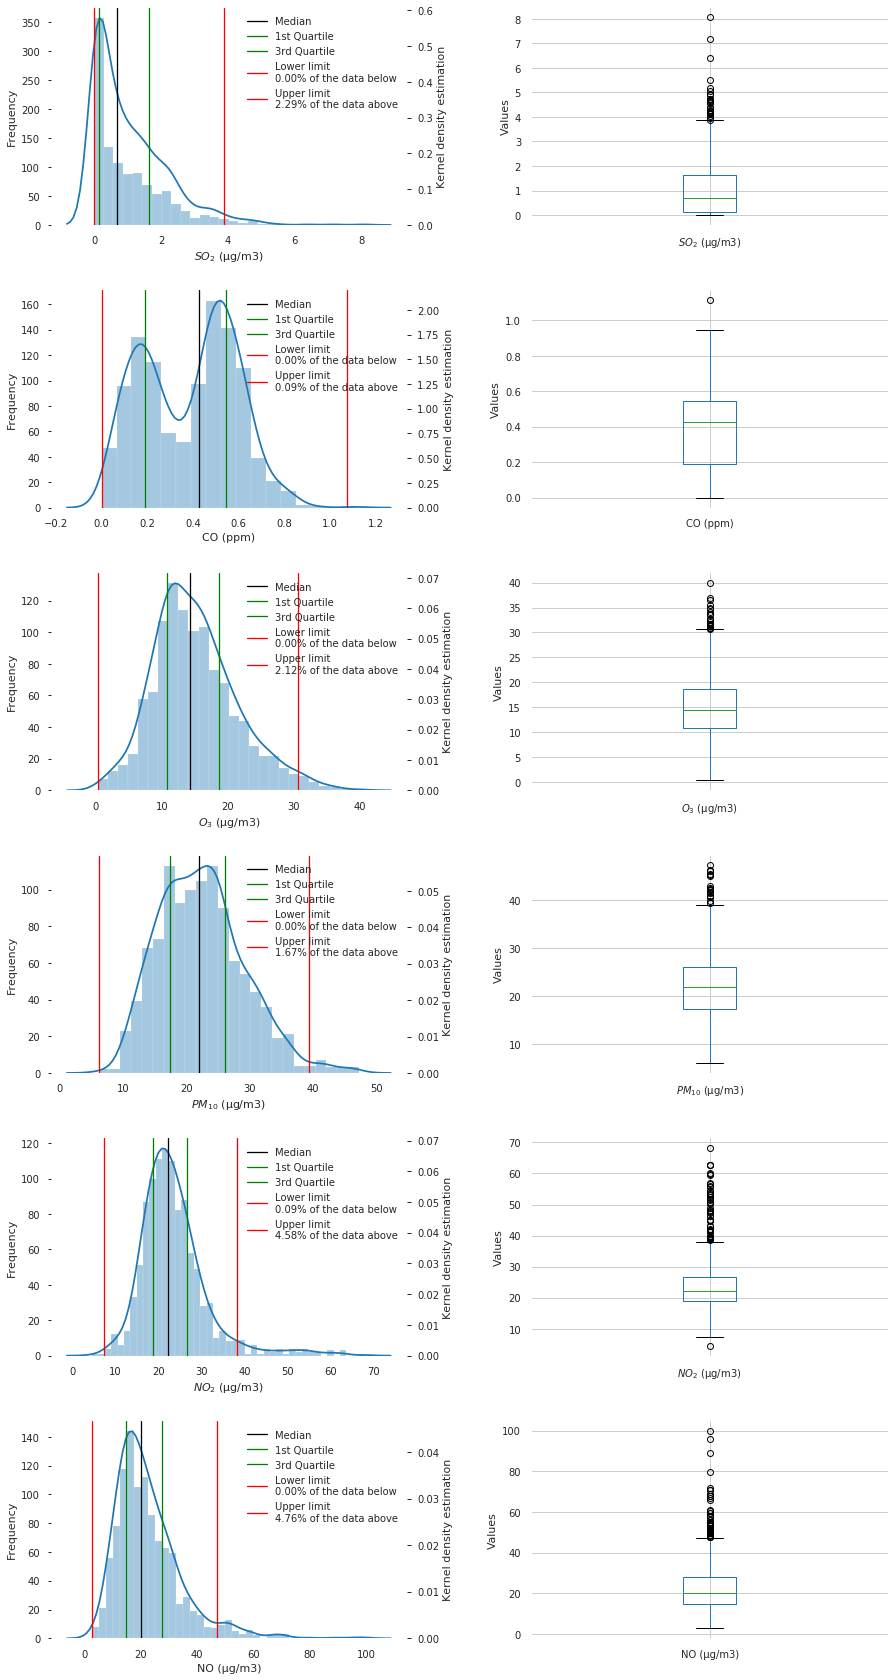

'AV BARROS REIS'

<Figure size 432x288 with 0 Axes>

'CAMPO GRANDE'

<Figure size 432x288 with 0 Axes>

'DIQUE DO TORORÓ'

<Figure size 432x288 with 0 Axes>

'ITAIGARA'

<Figure size 432x288 with 0 Axes>

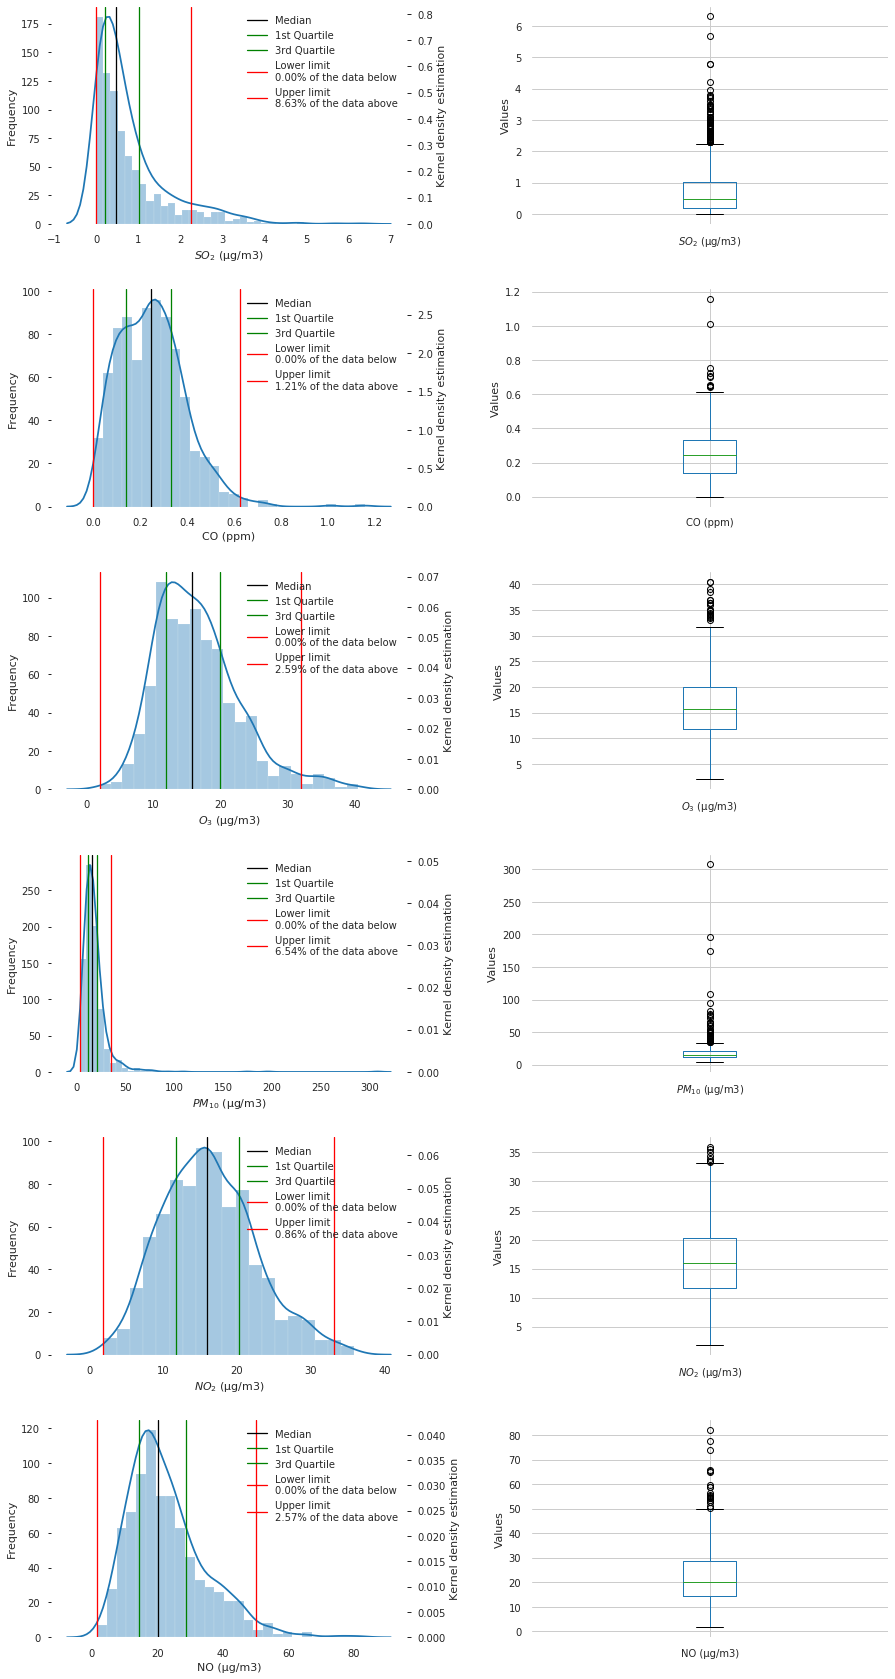

'PARALELA-CAB'

<Figure size 432x288 with 0 Axes>

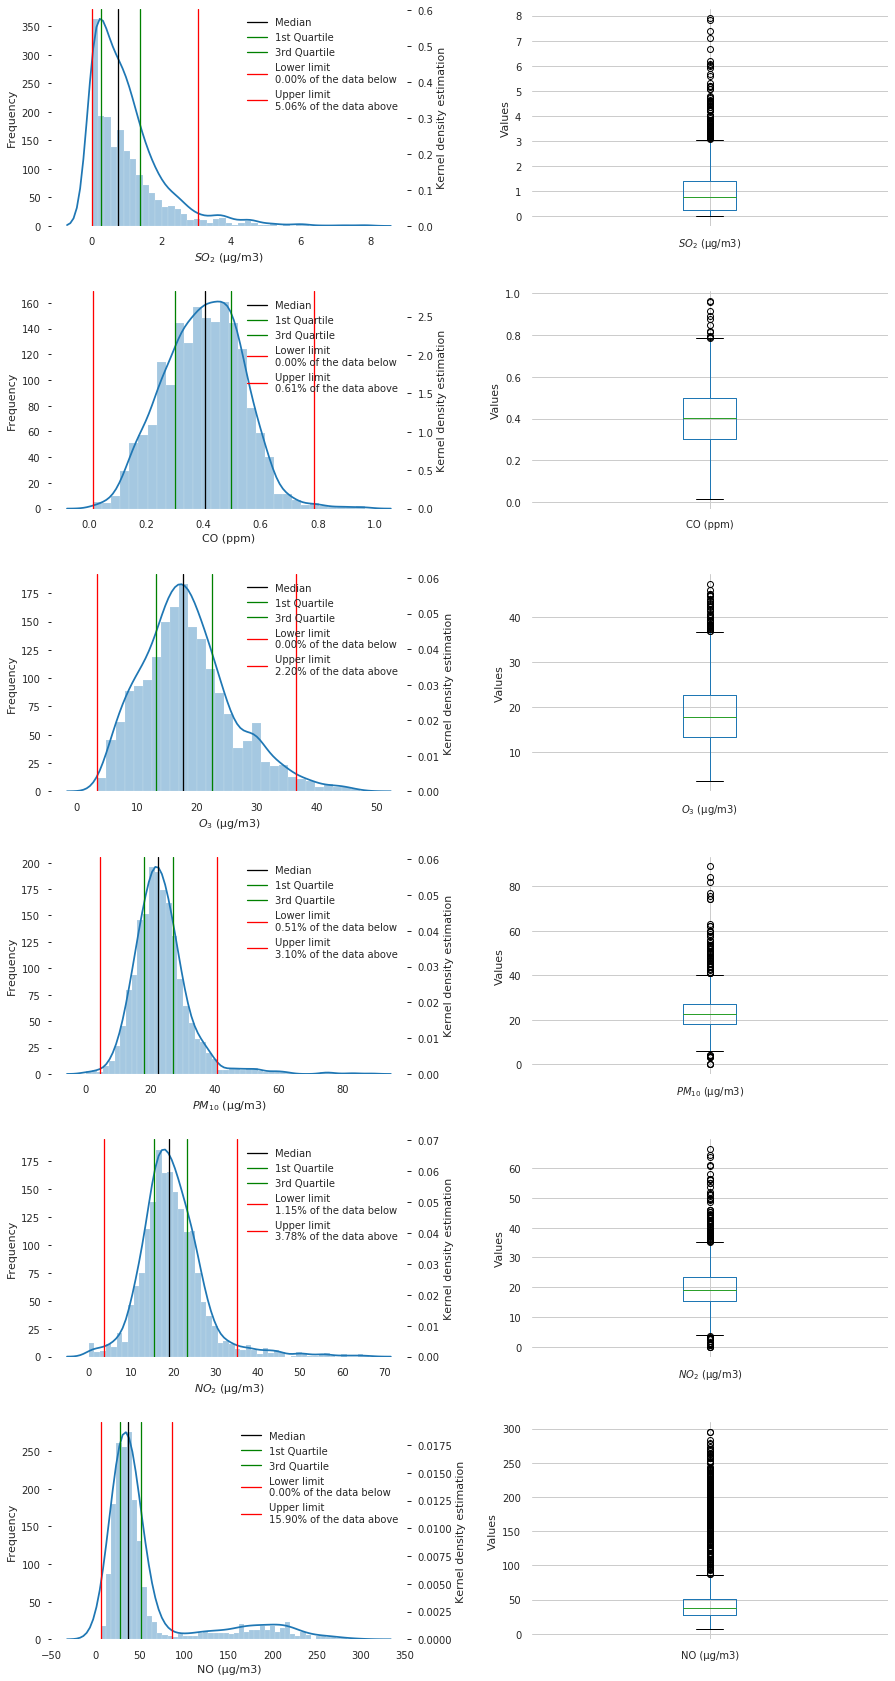

'PIRAJÁ'

<Figure size 432x288 with 0 Axes>

'RIO VERMELHO'

<Figure size 432x288 with 0 Axes>

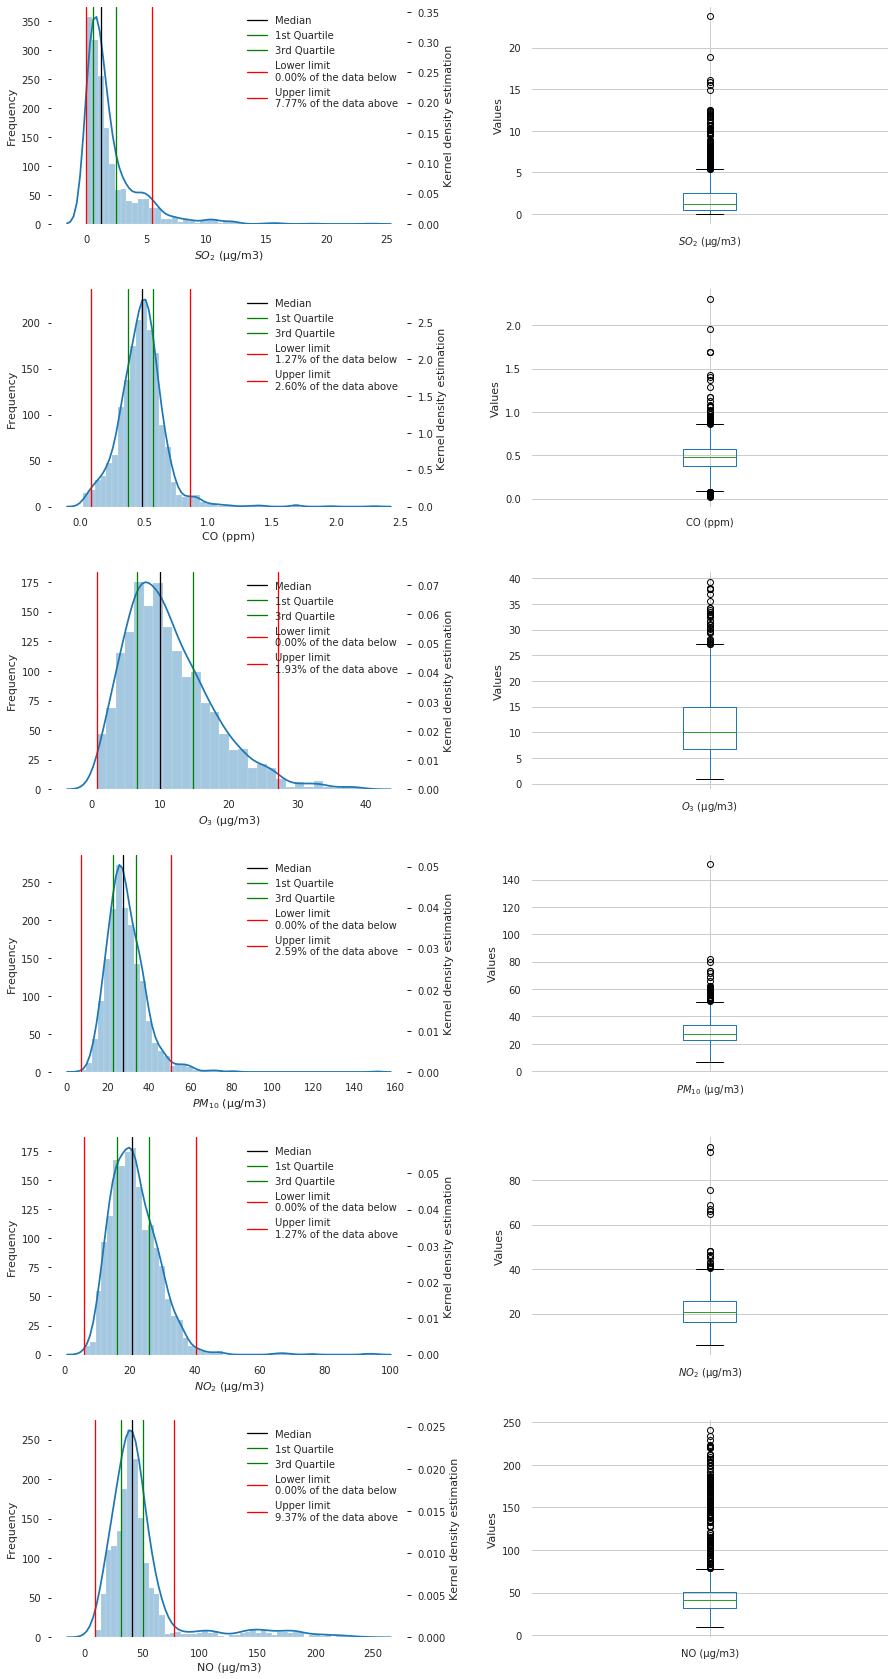

<Figure size 432x288 with 0 Axes>

In [20]:
stations = np.unique(df_airq['station'])

sync_path(f'{PATH_RESULTS}/charts/distplot')

for st in stations:
    aux = df_airq.loc[df_airq['station'] == st]
    aux = aux[COLS_AIRQ]
    aux = aux.groupby(pd.Grouper(freq='D')).mean()
    aux.fillna(limit=2, method='ffill', inplace=True)
    
    out = f'{PATH_RESULTS}/charts/distplot/{st}-distplot-daily_average.png'
    display(st)
    plot_distributions(aux, out)

Padrões de qualidado do ar da resolução CONAMA Nº 491/2018:

Poluente Atmosférico|Período de Referência|PI-1 µg/m³|PI-2 µg/m³|PI-3 µg/m³|PF µg/m³|PF ppm
--|--|--|--|--|--|--
Material Particulado - PM10|24 horas|120|100|75|50|-
Material Particulado - PM10|Anual ♥|40|35|30|20|-
Material Particulado - MP2.5|24 horas|60|50|37|25|-
Material Particulado - MP2.5|Anual ♥|20|17|15|10|-
Dióxido de Enxofre - SO2|24 horas|125|50|30|20|-
Dióxido de Enxofre - SO2|Anual ♥|40|30|20|-|-
Dióxido de Nitrogênio - NO2|1 hora ♦|260|240|220|200|-
Dióxido de Nitrogênio - NO2|Anual ♥|60|50|45|40|-
Ozônio - O3|8 horas ♣|140|130|120|100|-
Fumaça|24 horas|120|100|75|50|-
Fumaça|Anual ♥|40|35|30|20|-
Monóxido de Carbono - CO|8 horas ♣|-|-|-|-|9
Partículas Totais em Suspensão - PTS|24 horas|-|-|-|240|-
Partículas Totais em Suspensão - PTS|Anual ♠|-|-|-|80|-
Chumbo - Pb •|Anual ♥|-|-|-|0.5|-

- ♥ média aritmética anual
- ♦ média horária
- ♣ máxima média móvel obtida no dia
- ♠ média geométrica anual
- • medido nas partículas totais em suspensão

- PI: padrões estabelecidos como valores temporários a serem cumpridos em etapas
- PF: valores guia definidos pela Organização Mundial da Saúda - OMS em 2005

Gerando gráfico histórico com os índices de polução registrados comprando-os as estimativas finais da resolução do CONAMA

In [21]:
cs = {
    r'$PM_{10}$ (µg/m3)': 50, # daily, 20 yearly
    r'$SO_2$ (µg/m3)': 20, # daily, not yearly
    r'$NO_2$ (µg/m3)': 200, # hourly, 40 yearly
    r'$O_3$ (µg/m3)': 100, # mooving average 8h
    'CO (ppm)': 9, # mooving average 8h
#     'NO (µg/m3)' # nothing
}

2013-12-31    0.914879
2014-12-31    1.251827
2015-12-31    0.970227
Freq: A-DEC, Name: AV ACM - DETRAN [$SO_2$ (µg/m3)], dtype: float64

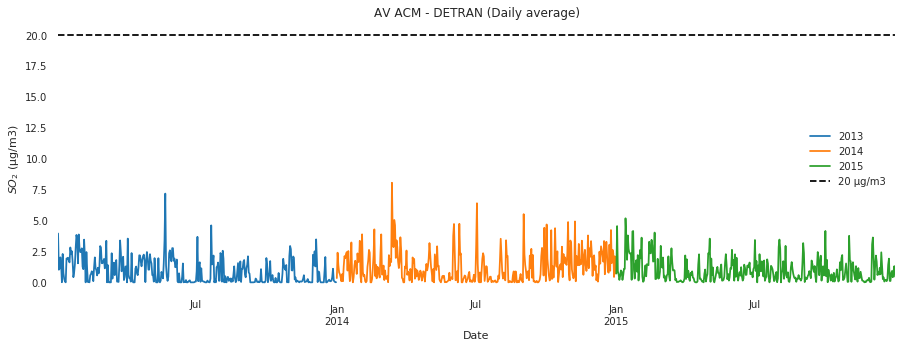

<Figure size 432x288 with 0 Axes>

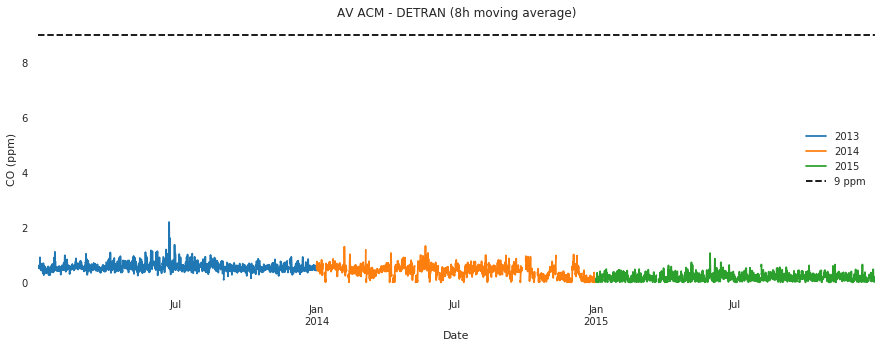

<Figure size 432x288 with 0 Axes>

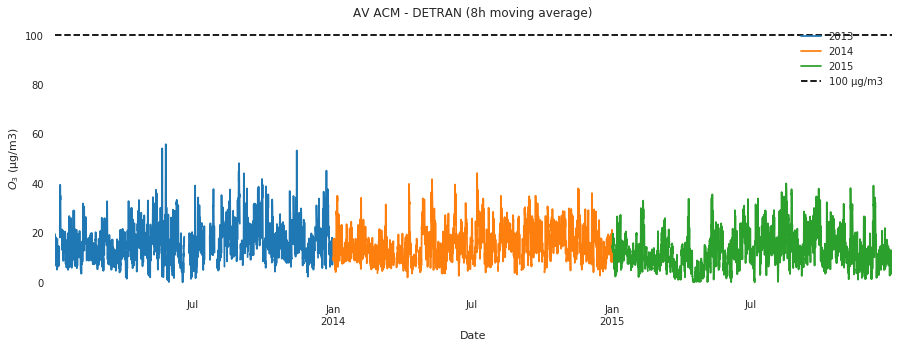

2013-12-31    20.443409
2014-12-31    22.309305
2015-12-31    24.243606
Freq: A-DEC, Name: AV ACM - DETRAN [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

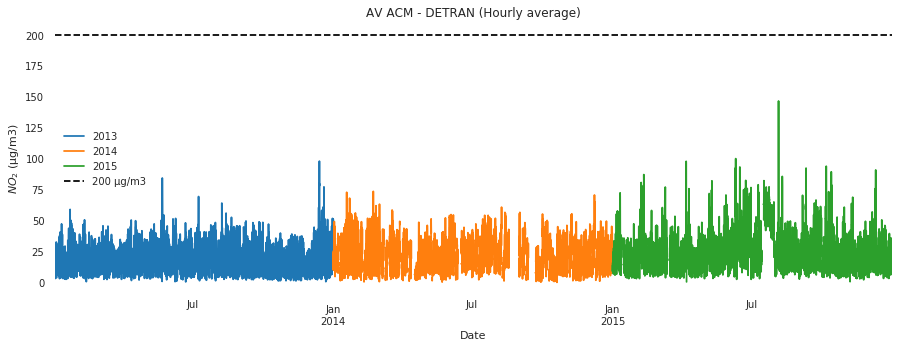

2013-12-31    4.522478
2014-12-31    1.706723
2015-12-31    0.807618
Freq: A-DEC, Name: AV BARROS REIS [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

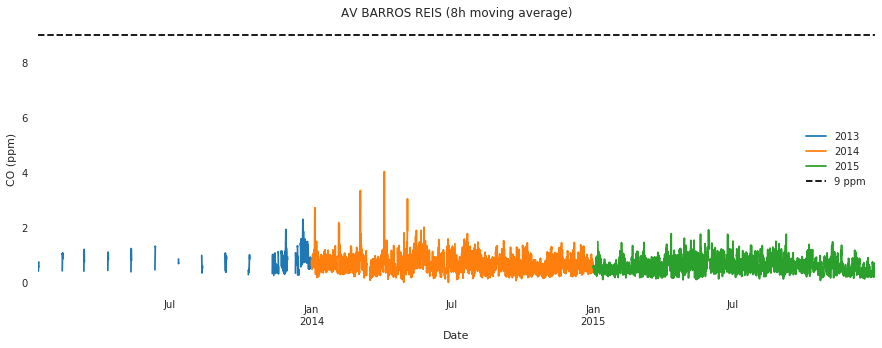

<Figure size 432x288 with 0 Axes>

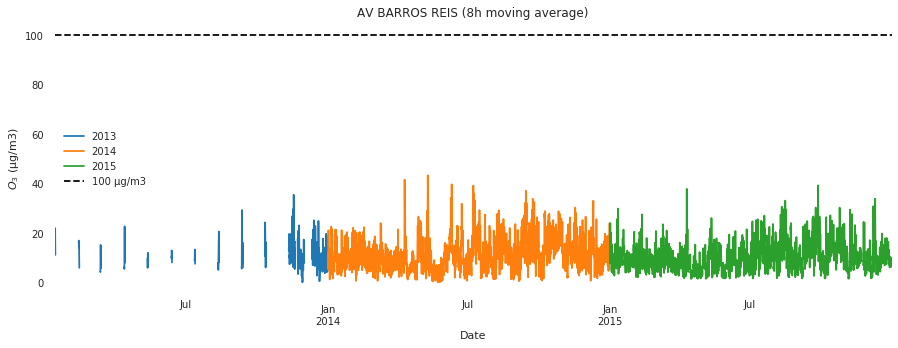

2013-12-31    48.049004
2014-12-31    44.015043
2015-12-31    44.774884
Freq: A-DEC, Name: AV BARROS REIS [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

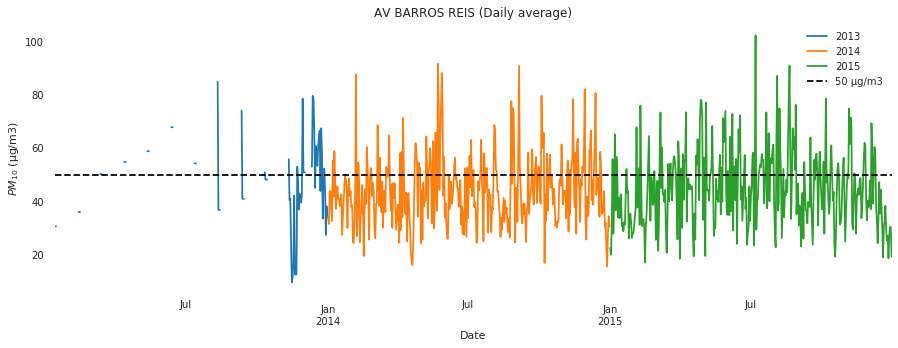

<Figure size 432x288 with 0 Axes>

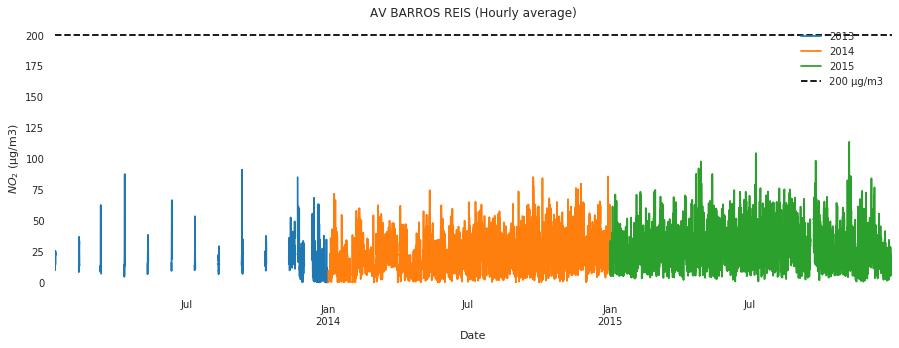

2011-12-31    1.302341
2012-12-31    0.675085
2013-12-31    0.466007
2014-12-31    0.524935
2015-12-31    1.190059
Freq: A-DEC, Name: CAMPO GRANDE [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

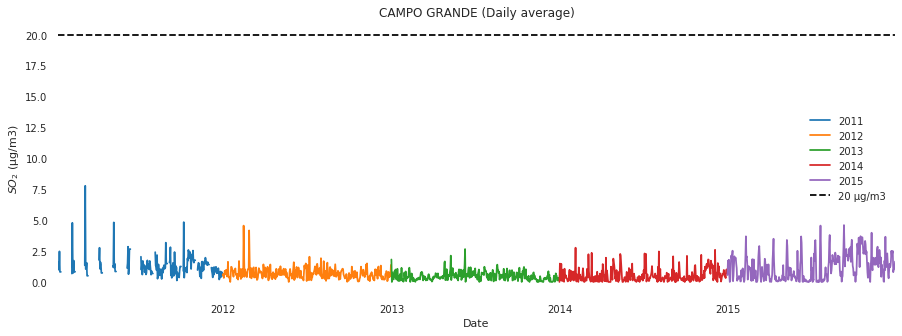

<Figure size 432x288 with 0 Axes>

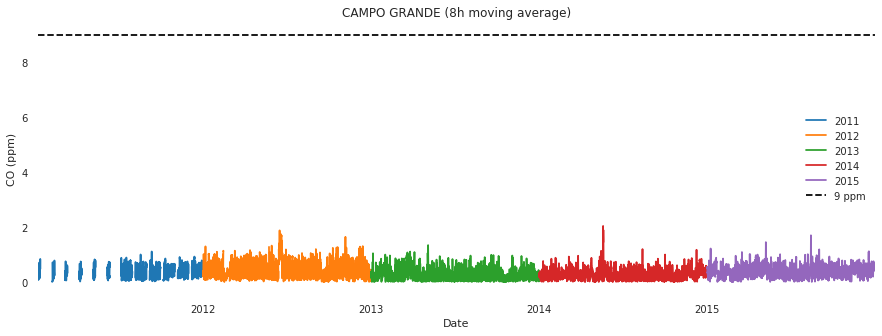

<Figure size 432x288 with 0 Axes>

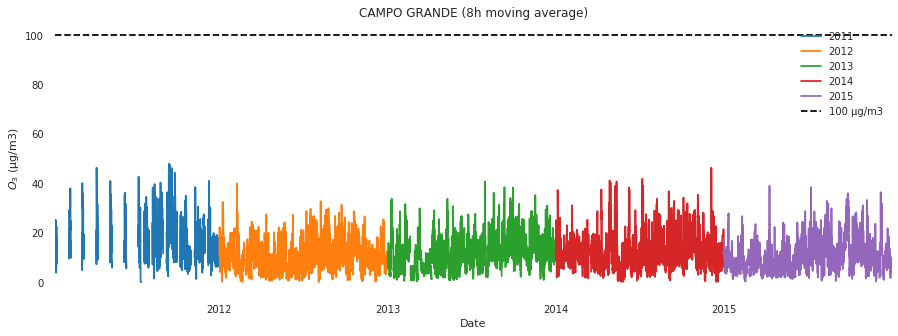

2011-12-31    21.499709
2012-12-31    18.089188
2013-12-31    23.654547
2014-12-31    20.946503
2015-12-31    20.933818
Freq: A-DEC, Name: CAMPO GRANDE [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

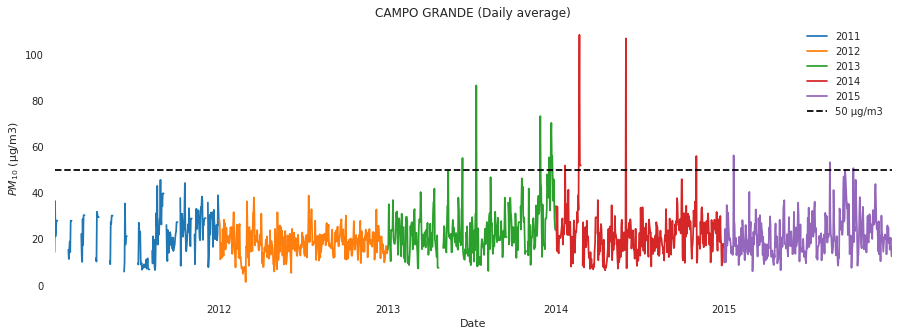

<Figure size 432x288 with 0 Axes>

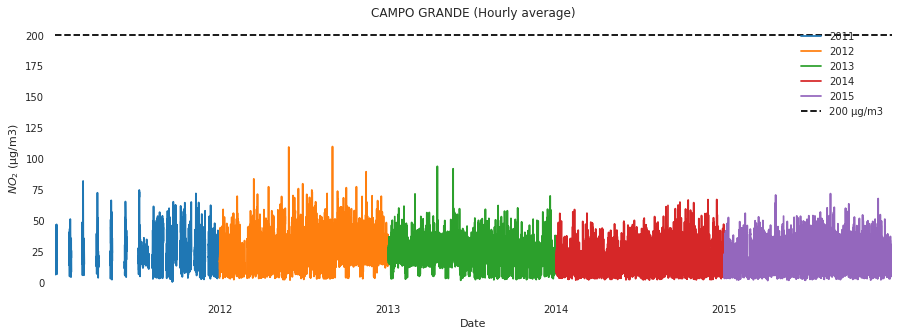

2011-12-31    1.071059
2012-12-31    1.255378
2013-12-31    1.017162
2014-12-31    0.778739
2015-12-31    0.917055
Freq: A-DEC, Name: DIQUE DO TORORÓ [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

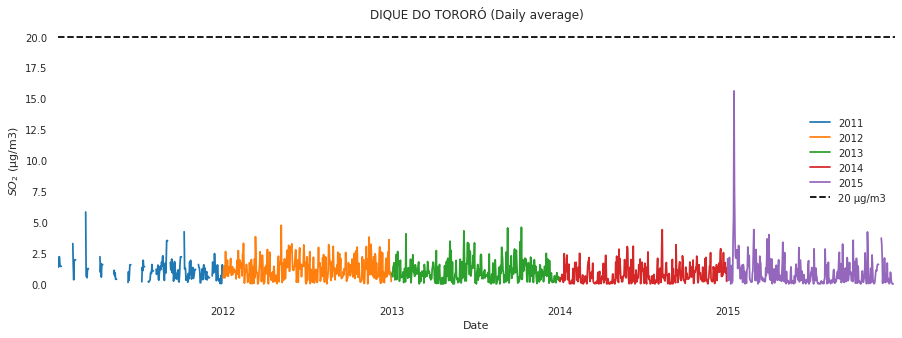

<Figure size 432x288 with 0 Axes>

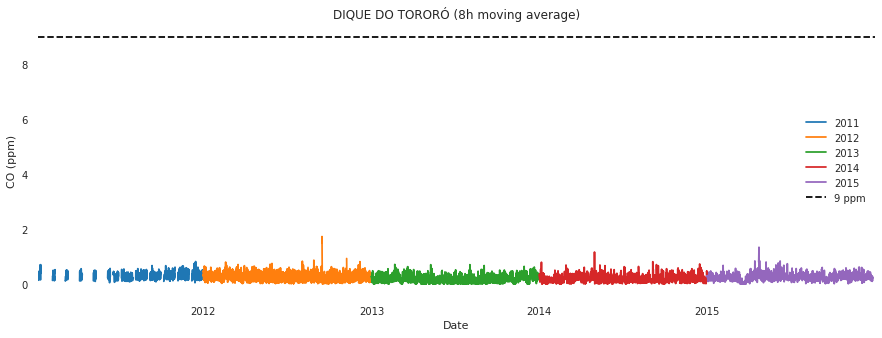

<Figure size 432x288 with 0 Axes>

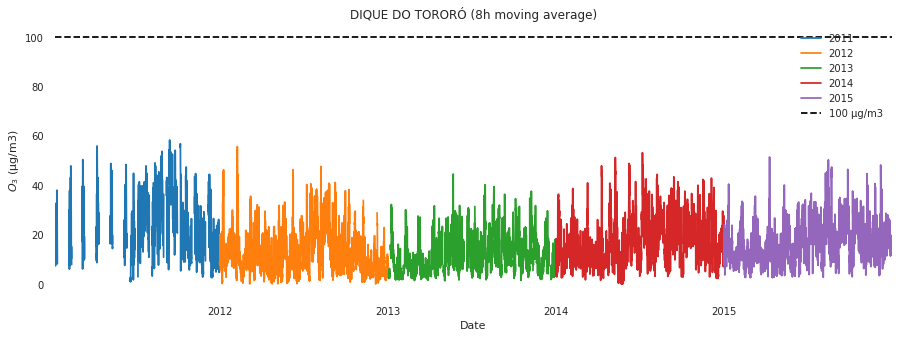

2011-12-31    25.497547
2012-12-31    31.117732
2013-12-31    22.475457
2014-12-31    18.733246
2015-12-31    19.414345
Freq: A-DEC, Name: DIQUE DO TORORÓ [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

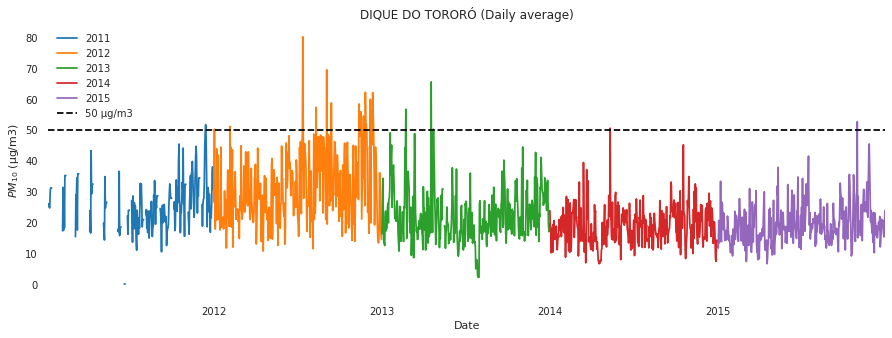

<Figure size 432x288 with 0 Axes>

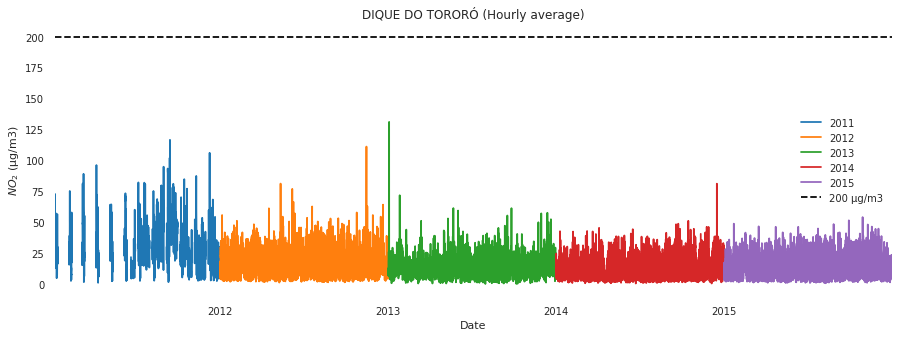

2013-12-31    0.460780
2014-12-31    1.024209
2015-12-31    0.677712
Freq: A-DEC, Name: ITAIGARA [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

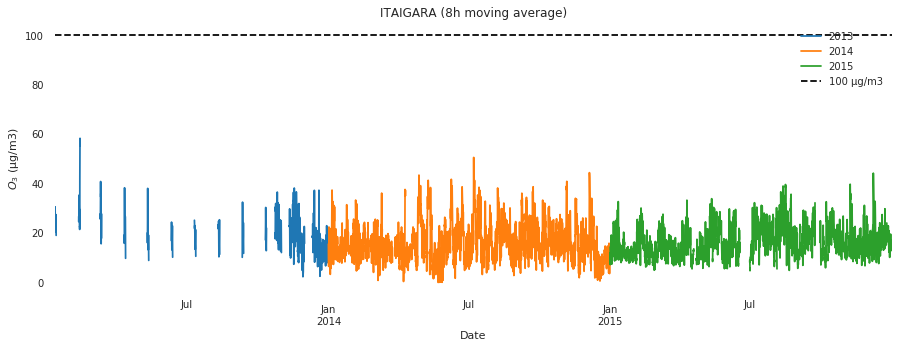

2013-12-31    27.899052
2014-12-31    19.546136
2015-12-31    16.030319
Freq: A-DEC, Name: ITAIGARA [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

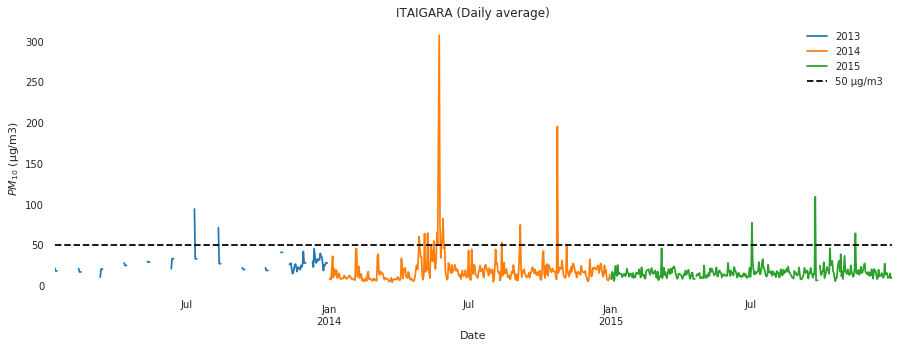

<Figure size 432x288 with 0 Axes>

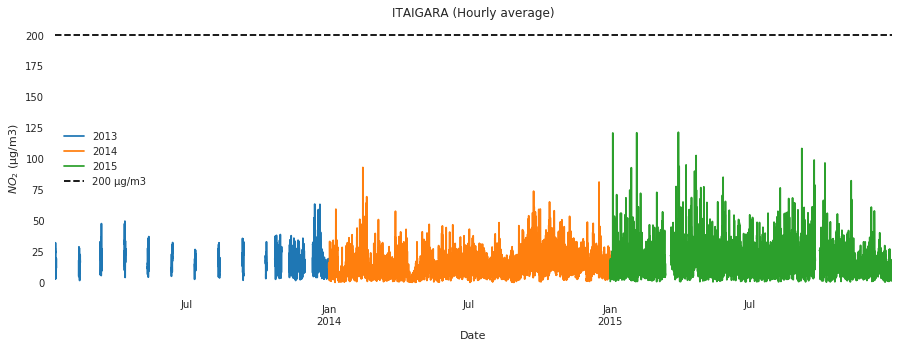

2011-12-31    0.563553
2012-12-31    1.136509
2013-12-31    0.704577
2014-12-31    1.335449
2015-12-31    1.297508
Freq: A-DEC, Name: PARALELA-CAB [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

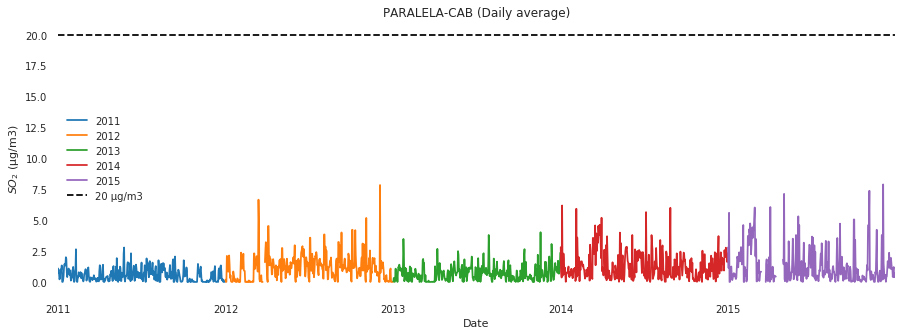

<Figure size 432x288 with 0 Axes>

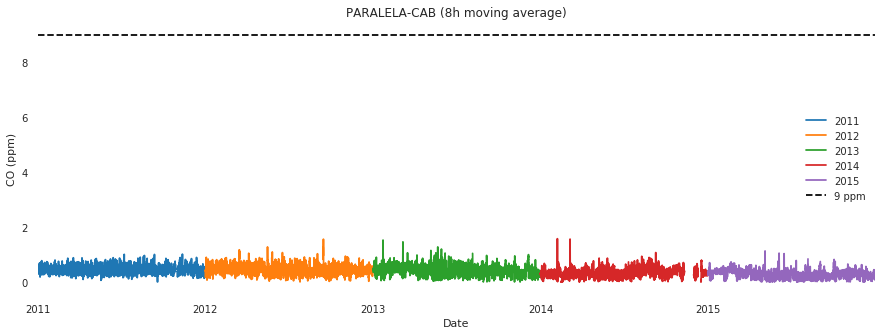

<Figure size 432x288 with 0 Axes>

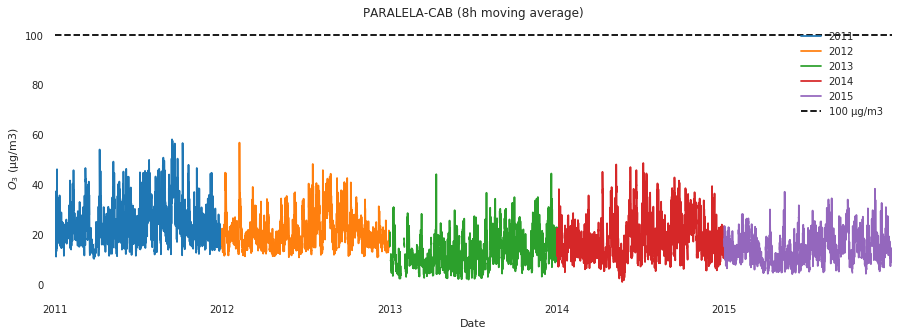

2011-12-31    25.840097
2012-12-31    25.742280
2013-12-31    21.813153
2014-12-31    25.080155
2015-12-31    18.823591
Freq: A-DEC, Name: PARALELA-CAB [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

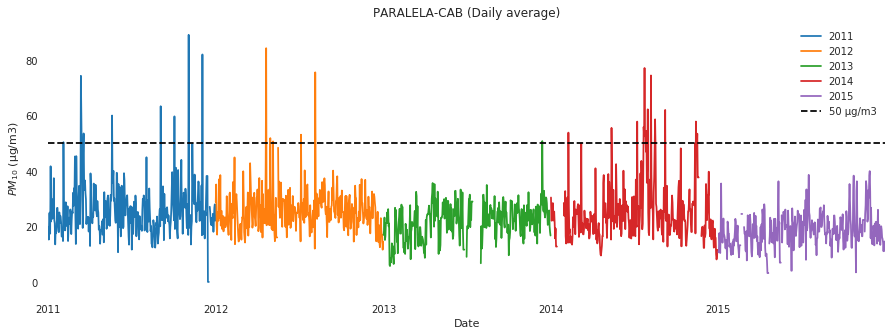

<Figure size 432x288 with 0 Axes>

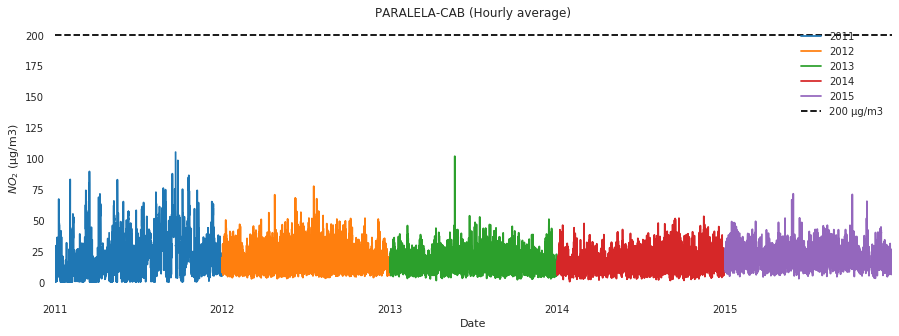

2011-12-31    0.723746
2012-12-31    0.885833
2013-12-31    1.756505
2014-12-31    0.896092
2015-12-31    1.487919
Freq: A-DEC, Name: PIRAJÁ [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

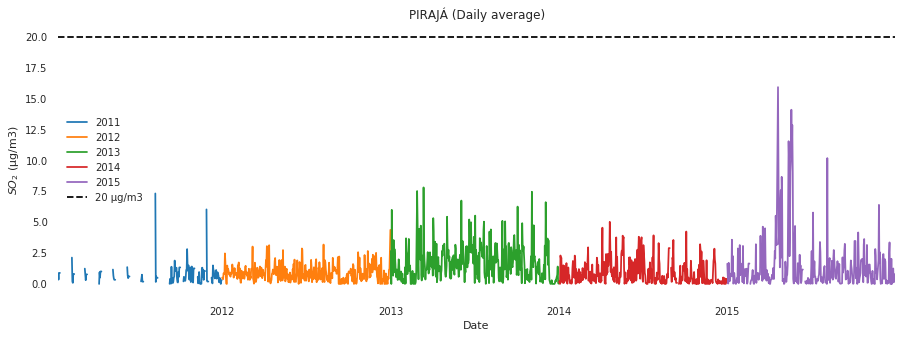

<Figure size 432x288 with 0 Axes>

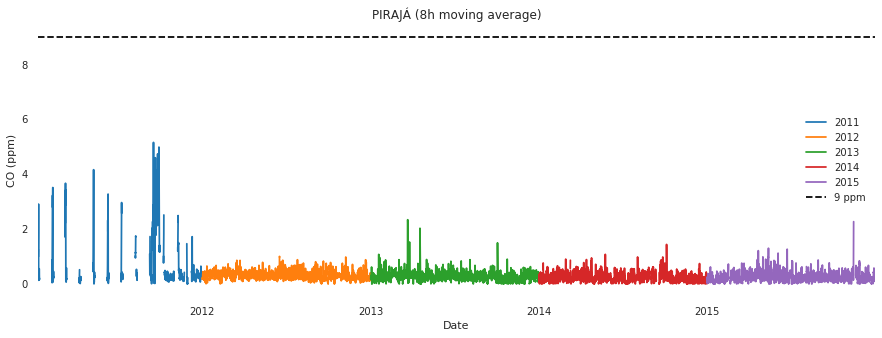

<Figure size 432x288 with 0 Axes>

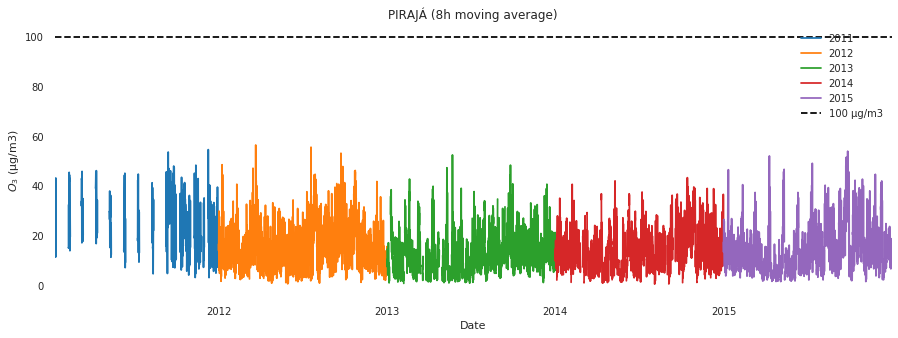

2011-12-31    30.093578
2012-12-31    28.796170
2013-12-31    30.457060
2014-12-31    23.925045
2015-12-31    19.814650
Freq: A-DEC, Name: PIRAJÁ [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

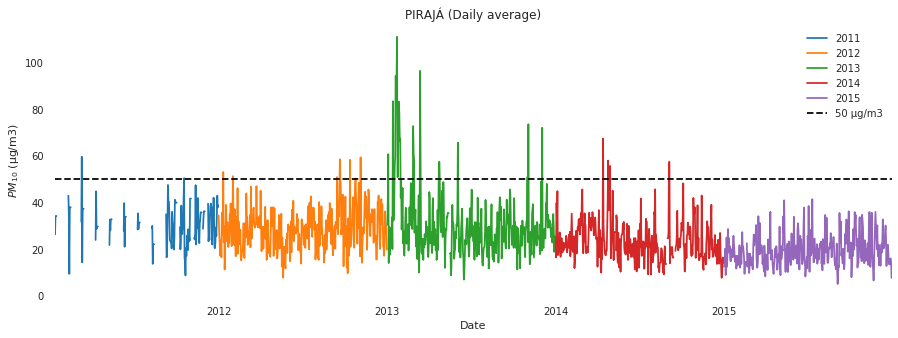

<Figure size 432x288 with 0 Axes>

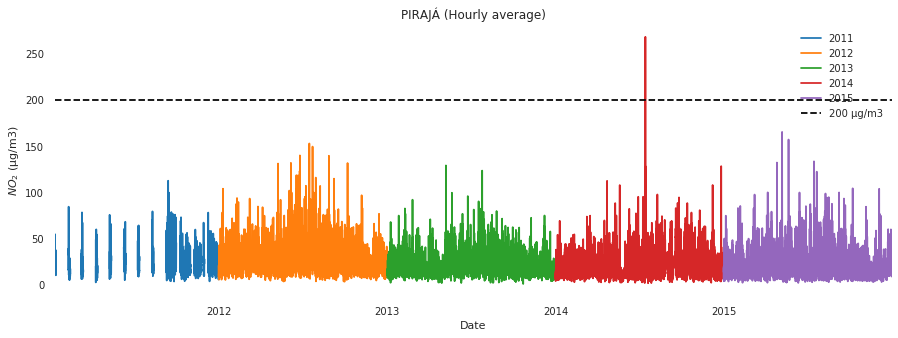

2011-12-31    1.175668
2012-12-31    0.586627
2013-12-31    2.774894
2014-12-31    2.954857
2015-12-31    2.153386
Freq: A-DEC, Name: RIO VERMELHO [$SO_2$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

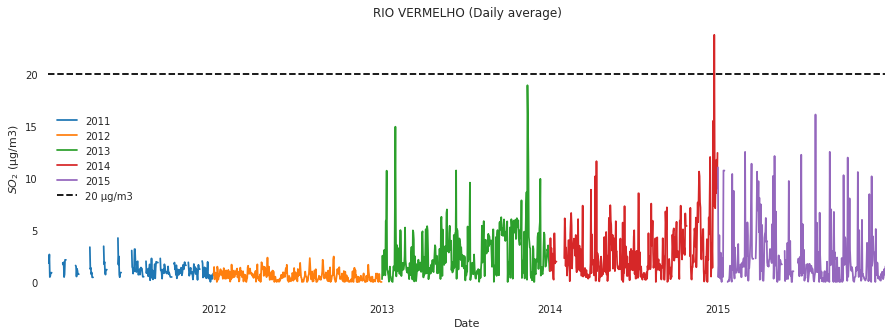

<Figure size 432x288 with 0 Axes>

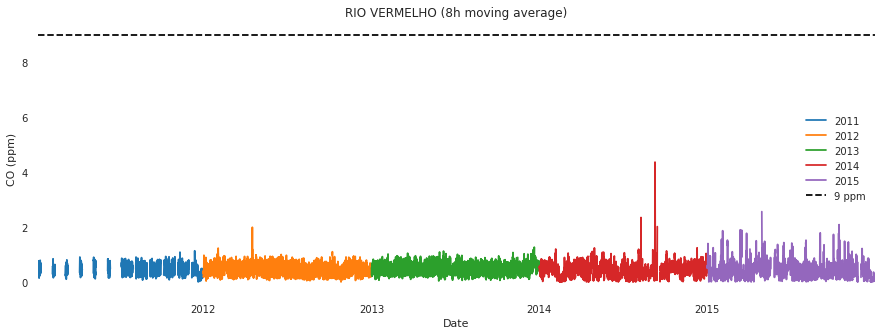

<Figure size 432x288 with 0 Axes>

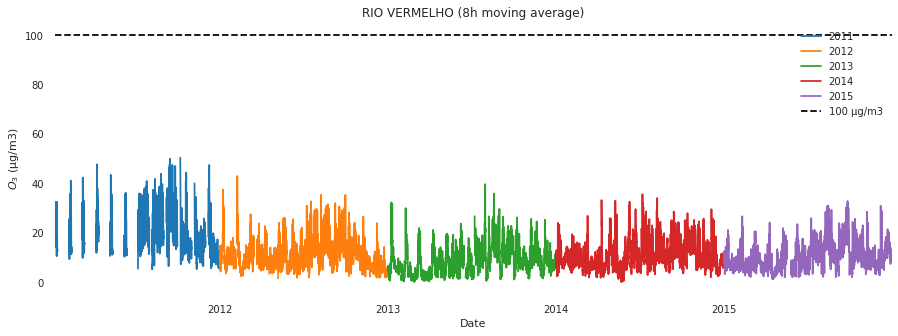

2011-12-31    29.792537
2012-12-31    30.334250
2013-12-31    29.484838
2014-12-31    29.842378
2015-12-31    24.211674
Freq: A-DEC, Name: RIO VERMELHO [$PM_{10}$ (µg/m3)], dtype: float64

<Figure size 432x288 with 0 Axes>

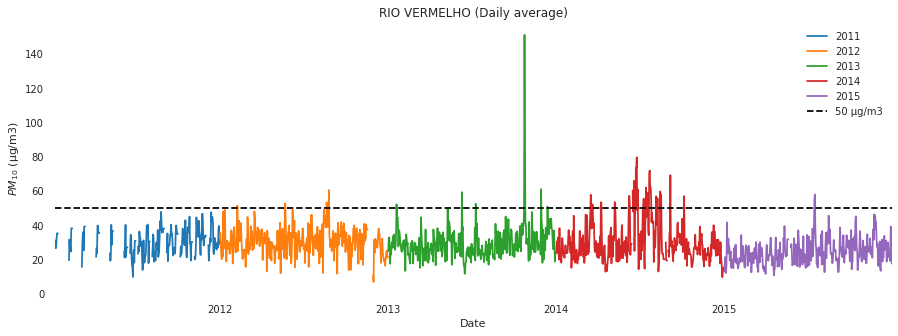

<Figure size 432x288 with 0 Axes>

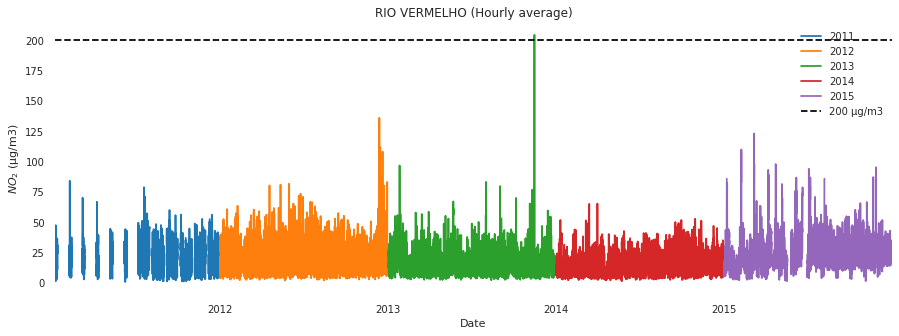

<Figure size 432x288 with 0 Axes>

In [32]:
cs_yearly = {}
cs_yearly[r'$PM_{10}$ (µg/m3)'] = pd.DataFrame()
cs_yearly[r'$SO_2$ (µg/m3)'] = pd.DataFrame()
cs_yearly[r'$SO_2$ (µg/m3)'] = pd.DataFrame()

stations = np.unique(df_airq['station'])
sync_path(f'{PATH_RESULTS}/charts/historic')

for st in stations:
    
    sync_path(f'{PATH_RESULTS}/charts/historic/{st}')
    aux = df_airq.loc[df_airq['station'] == st]
    aux = aux[COLS_AIRQ]

    for col in aux:
        if (col == r'$PM_{10}$ (µg/m3)') or (col == r'$SO_2$ (µg/m3)'):
            data = aux[col].groupby(pd.Grouper(freq='D')).mean()
            data.fillna(limit=2, method='ffill', inplace=True)
            method = 'Daily average'
            
            yearly = aux[col].groupby(pd.Grouper(freq='Y')).mean()
            yearly.rename(f'{st} [{yearly.name}]', inplace=True)
            cs_yearly[col] = pd.concat([cs_yearly[col], yearly], axis=1)
            display(yearly)

        elif col == r'$NO_2$ (µg/m3)':
            data = aux[col]
            data.fillna(limit=2, method='ffill', inplace=True)
            method = 'Hourly average'

        elif (col == r'$O_3$ (µg/m3)') or (col == 'CO (ppm)'):
            data = aux[col]
            data.fillna(limit=2, method='ffill', inplace=True)
            data = data.rolling(8).mean()
            method = '8h moving average'
        
        else:
            continue


        fig, ax = plt.subplots()
        years = np.unique(data.index.year)
#         plt.xticks([], [])
        for year in years:
            data.loc[data.index.year == year].plot(
                figsize=(15,5), label=year, title=f'{st} ({method})', ax=ax
            )

        ug = re.search(r'\((.*?)\)', col).group(1)
        plt.axhline(
            y=cs[col], linestyle='--', color='black', label=f'{cs[col]} {ug}'
        )
        ax.set(ylabel=col, xlabel='Date')
        # Define the date format
#         fmt = mdates.DateFormatter('%b-%y')
#         locator = mdates.MonthLocator(bymonth=[3,6,9,12])
#         fig.autofmt_xdate()
#         ax.xaxis.set_major_locator(locator)
#         ax.xaxis.set_minor_formatter(fmt)
        ax.legend()
        plt.show()

        col = re.sub(r'[^\w]', '', col)
        out = f'{PATH_RESULTS}/charts/historic/{st}/{col}.png'
        plt.savefig(out)

In [34]:
sync_path(f'{PATH_RESULTS}/tables/yearly_average')

for specie in cs_yearly:
    out = re.sub(r'[^\w]', '', specie)
    cs_yearly[specie].to_csv(f'{PATH_RESULTS}/tables/yearly_average/{out}.csv')
    display(cs_yearly[specie])

AV ACM - DETRAN [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                                  NaN   
2012-12-31 00:00:00                                  NaN   
2013-12-31 00:00:00                            20.443409   
2014-12-31 00:00:00                            22.309305   
2015-12-31 00:00:00                            24.243606   

                     AV BARROS REIS [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                                 NaN   
2012-12-31 00:00:00                                 NaN   
2013-12-31 00:00:00                           48.049004   
2014-12-31 00:00:00                           44.015043   
2015-12-31 00:00:00                           44.774884   

                     CAMPO GRANDE [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                         21.499709   
2012-12-31 00:00:00                         18.089188   
2013-12-31 00:00:00                         23.654547   
2014-12-31 00:00:00                         20.946503   
2015-12-31 00:00:00                         20.933818   

                     DIQUE DO TORORÓ [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                            25.497547   
2012-12-31 00:00:00                            31.117732   
2013-12-31 00:00:00                            22.475457   
2014-12-31 00:00:00                            18.733246   
2015-12-31 00:00:00                            19.414345   

                     ITAIGARA [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                           NaN   
2012-12-31 00:00:00                           NaN   
2013-12-31 00:00:00                     27.899052   
2014-12-31 00:00:00                     19.546136   
2015-12-31 00:00:00                     16.030319   

                     PARALELA-CAB [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                         25.840097   
2012-12-31 00:00:00                         25.742280   
2013-12-31 00:00:00                         21.813153   
2014-12-31 00:00:00                         25.080155   
2015-12-31 00:00:00                         18.823591   

                     PIRAJÁ [$PM_{10}$ (µg/m3)]  \
2011-12-31 00:00:00                   30.093578   
2012-12-31 00:00:00                   28.796170   
2013-12-31 00:00:00                   30.457060   
2014-12-31 00:00:00                   23.925045   
2015-12-31 00:00:00                   19.814650   

                     RIO VERMELHO [$PM_{10}$ (µg/m3)]  
2011-12-31 00:00:00                         29.792537  
2012-12-31 00:00:00                         30.334250  
2013-12-31 00:00:00                         29.484838  
2014-12-31 00:00:00                         29.842378  
2015-12-31 00:00:00                         24.211674

AV ACM - DETRAN [$SO_2$ (µg/m3)]  \
2011-12-31 00:00:00                               NaN   
2012-12-31 00:00:00                               NaN   
2013-12-31 00:00:00                          0.914879   
2014-12-31 00:00:00                          1.251827   
2015-12-31 00:00:00                          0.970227   

                     AV BARROS REIS [$SO_2$ (µg/m3)]  \
2011-12-31 00:00:00                              NaN   
2012-12-31 00:00:00                              NaN   
2013-12-31 00:00:00                         4.522478   
2014-12-31 00:00:00                         1.706723   
2015-12-31 00:00:00                         0.807618   

                     CAMPO GRANDE [$SO_2$ (µg/m3)]  \
2011-12-31 00:00:00                       1.302341   
2012-12-31 00:00:00                       0.675085   
2013-12-31 00:00:00                       0.466007   
2014-12-31 00:00:00                       0.524935   
2015-12-31 00:00:00                       1.190059   

                     DIQUE DO TORORÓ [$SO_2$ (µg/m3)]  \
2011-12-31 00:00:00                          1.071059   
2012-12-31 00:00:00                          1.255378   
2013-12-31 00:00:00                          1.017162   
2014-12-31 00:00:00                          0.778739   
2015-12-31 00:00:00                          0.917055   

                     ITAIGARA [$SO_2$ (µg/m3)]  PARALELA-CAB [$SO_2$ (µg/m3)]  \
2011-12-31 00:00:00                        NaN                       0.563553   
2012-12-31 00:00:00                        NaN                       1.136509   
2013-12-31 00:00:00                   0.460780                       0.704577   
2014-12-31 00:00:00                   1.024209                       1.335449   
2015-12-31 00:00:00                   0.677712                       1.297508   

                     PIRAJÁ [$SO_2$ (µg/m3)]  RIO VERMELHO [$SO_2$ (µg/m3)]  
2011-12-31 00:00:00                 0.723746                       1.175668  
2012-12-31 00:00:00                 0.885833                       0.586627  
2013-12-31 00:00:00                 1.756505                       2.774894  
2014-12-31 00:00:00                 0.896092                       2.954857  
2015-12-31 00:00:00                 1.487919                       2.153386

---

### Weather

#### Dataframe

In [ ]:
df_wthr = pd.read_csv(F_WTHR, low_memory=False, compression='gzip')
df_wthr

#### Missingno

In [ ]:
msno.bar(df_wthr)

#### Profiling

In [ ]:
show_profiling(
    df_wthr,
    title=F_WTHR.split('/')[-1],
    f_out=f'{os.path.splitext(F_WTHR)[0]}.html'
)

#### Describe

In [ ]:
show_describe(df_wthr, columns=COLS_WTHR)

#### Plot

---

### Datasus

#### Dataframe

In [ ]:
df_dsus = pd.read_csv(F_DSUS, low_memory=False, compression='gzip')
df_dsus

#### Missingno

In [ ]:
msno.bar(df_dsus)

#### Profiling

In [ ]:
show_profiling(
    df_dsus,
    title=f_dsus.split('/')[-1],
    f_out=f'{os.path.splitext(f_dsus)[0]}.html'
)

#### Describe

In [ ]:
show_describe(
    df_dsus,
    columns=[
        'UTI_MES_TO',
        'UTI_INT_TO',
        'VAL_SH',
        'VAL_SP',
        'DIAS_PERM',
    ]
)

#### Plot